In [2]:
import os
import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# =========================
# KONFIGURASI DATASET
# =========================

# Direktori utama dataset (Google Drive)
BASE_DIR = '/content/drive/MyDrive/Triad/Kuliah/Machine Learning/src/Lego/star-wars/'

# Nama kelas (7 karakter Star Wars berbentuk Lego)
names = [
    'YODA',
    'LUKE SKYWALKER',
    'R2-D2',
    'MACE WINDU',
    'GENERAL GRIEVIOUS',
    'KYLO REN',
    'JANGO FETT'
]

# Set seed agar hasil eksperimen reproducible
tf.random.set_seed(1)

In [21]:
# =========================
# MEMBUAT STRUKTUR FOLDER TRAIN / VAL / TEST
# =========================

# Jika folder train belum ada, buat struktur dataset
if not os.path.isdir(BASE_DIR + 'train/'):
    for name in names:
        os.makedirs(BASE_DIR + 'train/' + name)
        os.makedirs(BASE_DIR + 'val/' + name)
        os.makedirs(BASE_DIR + 'test/' + name)

In [39]:
# =========================
# MEMBAGI DATASET (SPLITTING)
# =========================

# Folder asli dataset (setiap folder = 1 kelas)
orig_folders = ['0001/', '0002/', '0003/', '0004/', '0005/', '0006/', '0007/']

# Loop setiap kelas
for folder_idx, folder in enumerate(orig_folders):

    # Ambil semua file gambar
    files = os.listdir(BASE_DIR + folder)
    number_of_images = len(files)

    # Hitung proporsi data
    n_train = int((number_of_images * 0.6) + 0.5)   # 60% training
    n_valid = int((number_of_images * 0.25) + 0.5)  # 25% validation
    n_test = number_of_images - n_train - n_valid   # sisanya testing

    print(number_of_images, n_train, n_valid, n_test)

    # Pindahkan file ke folder masing-masing
    for idx, file in enumerate(files):
        file_name = BASE_DIR + folder + file

        if idx < n_train:
            shutil.move(file_name, BASE_DIR + 'train/' + names[folder_idx])
        elif idx < n_train + n_valid:
            shutil.move(file_name, BASE_DIR + 'val/' + names[folder_idx])
        else:
            shutil.move(file_name, BASE_DIR + 'test/' + names[folder_idx])


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Triad/Kuliah/Machine Learning/src/Lego/star-wars/0001/'

In [4]:
# =========================
# IMAGE DATA GENERATOR
# =========================

# Generator data training (normalisasi pixel 0–255 → 0–1)
train_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # zoom_range=0.2,
    # shear_range=0.2,
    # horizontal_flip=True
    # augmentasi bisa ditambahkan di sini
)

# Generator validation & test (tanpa augmentasi)
valid_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# =========================
# MEMBACA DATASET DARI FOLDER
# =========================

train_batches = train_gen.flow_from_directory(
    BASE_DIR + 'train',
    target_size=(256, 256),   # Resize gambar
    class_mode='sparse',      # Label berupa integer (0–6)
    batch_size=4,
    shuffle=True,
    color_mode='rgb',
    classes=names             # Urutan kelas eksplisit
)

val_batches = valid_gen.flow_from_directory(
    BASE_DIR + 'val',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode='rgb',
    classes=names
)

test_batches = test_gen.flow_from_directory(
    BASE_DIR + 'test',
    target_size=(256, 256),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode='rgb',
    classes=names
)

Found 48 images belonging to 7 classes.
Found 21 images belonging to 7 classes.
Found 12 images belonging to 7 classes.


In [36]:
from google.colab import drive

In [ ]:
# =========================
# CEK BENTUK DATA
# =========================

train_batch = train_batches[0]
print(train_batch[0].shape)   # Shape image batch (batch, height, width, channel)
print(train_batch[1])         # Label batch

test_batch = test_batches[0]
print(test_batch[0].shape)
print(test_batch[1])

(4, 256, 256, 3)
[1. 0. 1. 6.]
(4, 256, 256, 3)
[2. 3. 2. 0.]


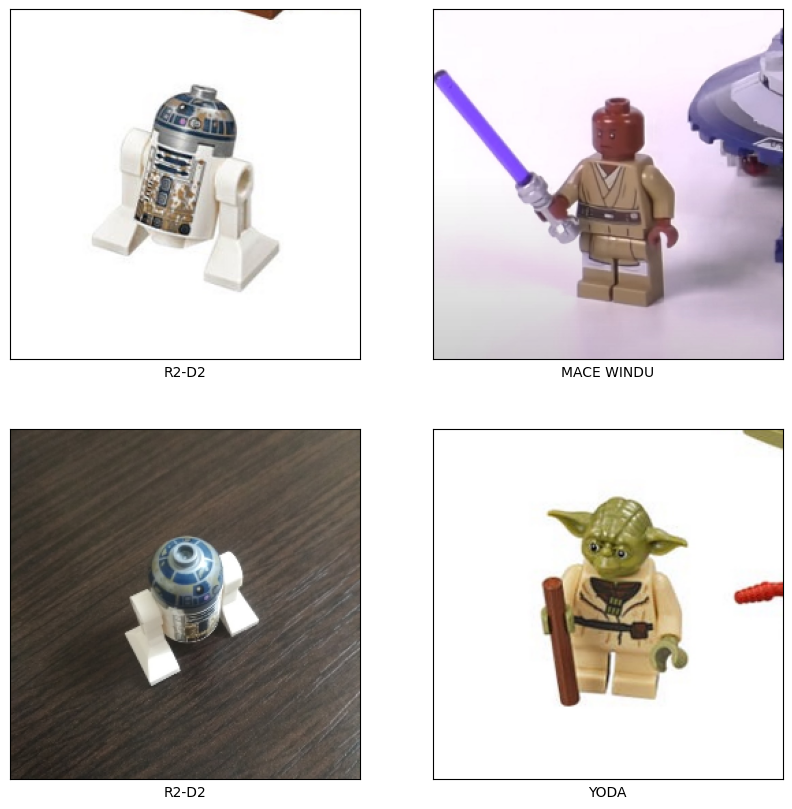

In [ ]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # Tampilkan gambar
        plt.imshow(batch[0][i])

        # Ambil label asli
        lbl = names[int(batch[1][i])]

        # Jika ada prediksi, tampilkan juga
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]

        plt.xlabel(lbl)
    plt.show()

# Tampilkan contoh data
show(test_batch)

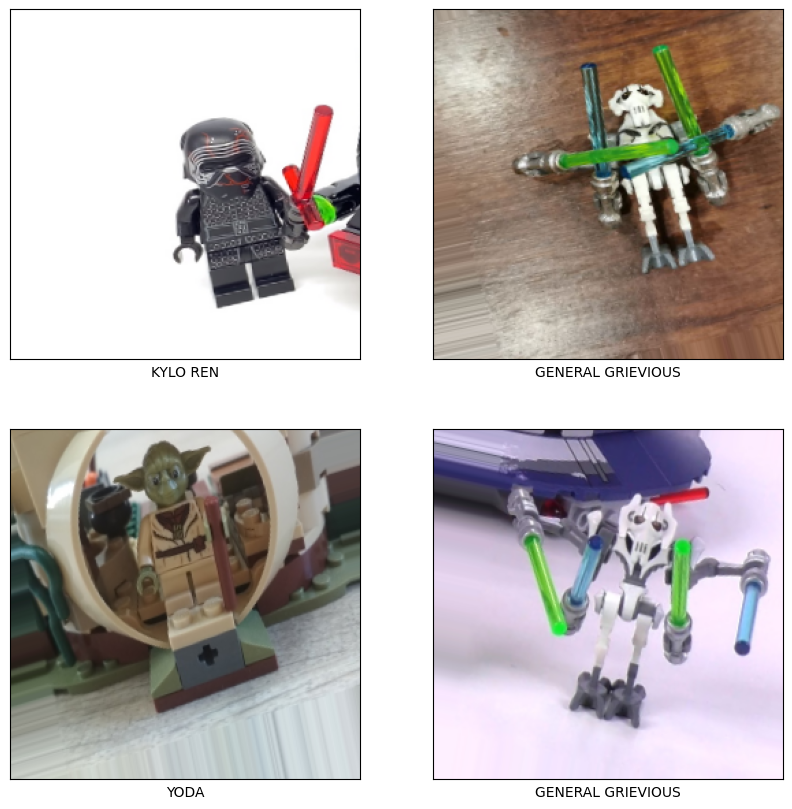

In [ ]:
show(train_batch)

In [ ]:
# =========================
# DEFINISI MODEL CNN
# =========================

model = keras.models.Sequential()

# Convolution layer pertama
model.add(layers.Conv2D(
    16, (3,3),
    strides=(1,1),
    padding='valid',
    activation='relu',
    input_shape=(256, 256, 3)
))

# Pooling untuk reduksi dimensi
model.add(layers.MaxPooling2D((2,2)))

# Convolution layer kedua
model.add(layers.Conv2D(32, 3, activation='relu'))

model.add(layers.Dropout(0.3))

# Pooling kedua
model.add(layers.MaxPooling2D((2,2)))

# Flatten feature map menjadi vektor
model.add(layers.Flatten())

# Fully connected layer
model.add(layers.Dense(64, activation='relu'))

# Output layer (7 kelas, tanpa softmax karena from_logits=True)
model.add(layers.Dense(7))

# Ringkasan arsitektur
print(model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 125, 125, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │     7,872,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,878,119 (30.05 MB)

 Trainable params: 7,878,119 (30.05 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# =========================
# KONFIGURASI TRAINING
# =========================

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ['accuracy']

model.compile(
    optimizer=optim,
    loss=loss,
    metrics=metrics
)

In [ ]:
epochs = 40

# Early stopping untuk mencegah overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=2
)

# =========================
# TRAINING MODEL
# =========================

history = model.fit(
    train_batches,
    validation_data=val_batches,
    callbacks=[early_stopping],
    epochs=epochs,
    verbose=2
)

Epoch 1/40
12/12 - 6s - 476ms/step - accuracy: 0.7500 - loss: 0.8951 - val_accuracy: 0.7619 - val_loss: 1.4827
Epoch 2/40
12/12 - 4s - 331ms/step - accuracy: 0.7292 - loss: 0.8120 - val_accuracy: 0.8095 - val_loss: 1.3530
Epoch 3/40
12/12 - 4s - 332ms/step - accuracy: 0.8125 - loss: 0.5910 - val_accuracy: 0.6667 - val_loss: 1.4187
Epoch 4/40
12/12 - 6s - 467ms/step - accuracy: 0.6250 - loss: 0.8918 - val_accuracy: 0.5714 - val_loss: 1.5468
Epoch 5/40
12/12 - 4s - 330ms/step - accuracy: 0.7083 - loss: 0.8072 - val_accuracy: 0.7143 - val_loss: 1.4717
Epoch 6/40
12/12 - 4s - 328ms/step - accuracy: 0.8125 - loss: 0.5936 - val_accuracy: 0.7619 - val_loss: 1.3201
Epoch 7/40
12/12 - 6s - 463ms/step - accuracy: 0.7083 - loss: 0.7303 - val_accuracy: 0.7619 - val_loss: 1.3473
Epoch 8/40
12/12 - 4s - 333ms/step - accuracy: 0.7292 - loss: 0.6728 - val_accuracy: 0.7143 - val_loss: 1.5567
Epoch 9/40
12/12 - 4s - 353ms/step - accuracy: 0.6250 - loss: 0.8516 - val_accuracy: 0.7143 - val_loss: 1.2016
E

In [ ]:
model.save('/content/drive/MyDrive/Triad/Kuliah/Machine Learning/Model/lego_model.h5')

In [ ]:
loaded_model = keras.models.load_model('/content/drive/MyDrive/Triad/Kuliah/Machine Learning/Model/lego_model.h5')

NameError: name 'history' is not defined

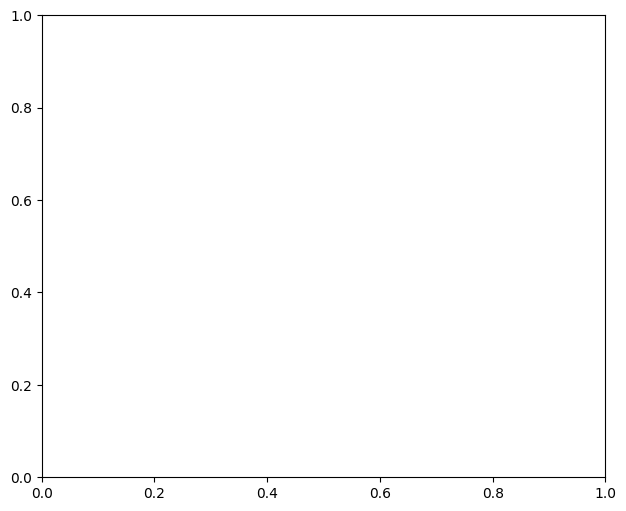

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15);

In [ ]:
# model.evaluate(test_batches, verbose=2)
loaded_model.evaluate(test_batches, verbose=2)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 - 2s - 688ms/step - accuracy: 0.6667 - loss: 1.5635


[1.5634870529174805, 0.6666666865348816]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
[6. 1. 4. 3.]
[3 0 4 3]


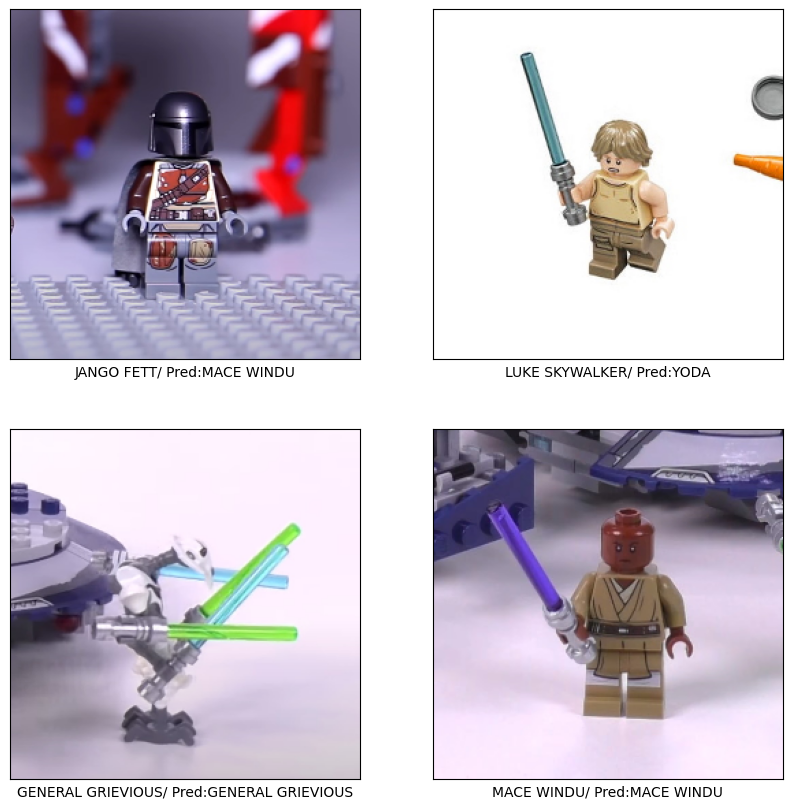

In [ ]:

# =========================
# PREDIKSI DATA TEST
# =========================

# predictions = model.predict(test_batches)
predictions = loaded_model.predict(test_batches)

# Konversi logits ke probabilitas
predictions = tf.nn.softmax(predictions)

# Ambil kelas dengan probabilitas tertinggi
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])  # Label asli
print(labels[0:4])         # Label prediksi

# Tampilkan hasil prediksi
show(test_batches[0], labels[0:4])

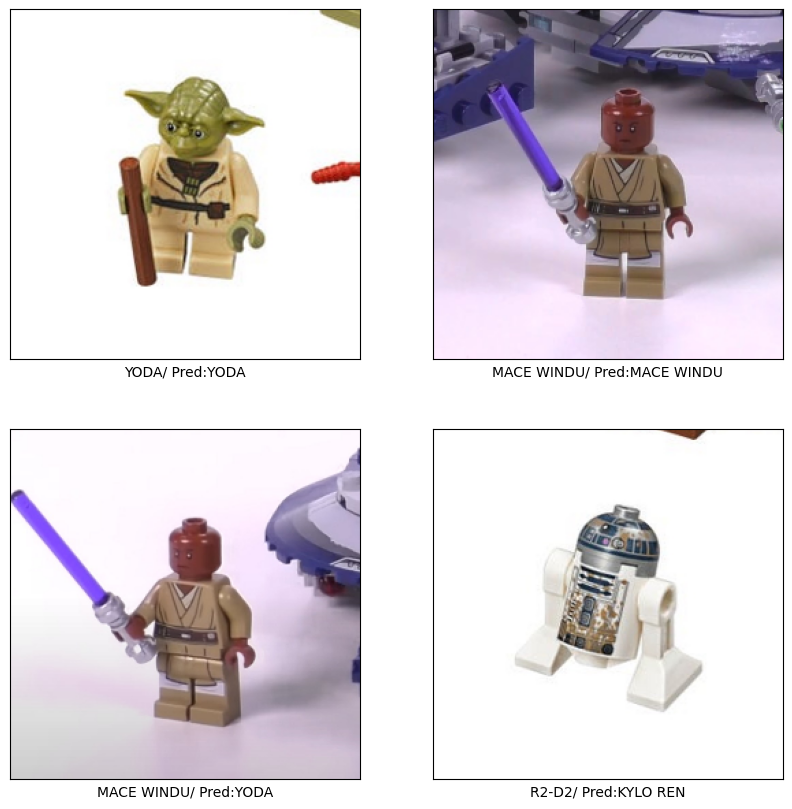

In [ ]:
show(test_batches[0], labels[0:4])

In [38]:
# Mengimpor arsitektur VGG16 pretrained dari TensorFlow Keras
vgg_model = tf.keras.applications.vgg16.VGG16()

# Menampilkan tipe objek model VGG16
print(type(vgg_model))

# Menampilkan ringkasan arsitektur VGG16 (layer, output shape, parameter)
vgg_model.summary()

<class 'keras.src.models.functional.Functional'>


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Membuat model Sequential kosong
model = keras.models.Sequential()

# Menyalin semua layer VGG16 kecuali layer terakhir (classifier bawaan)
for layer in vgg_model.layers[0:-1]:
  model.add(layer)


In [40]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Membekukan (freeze) semua layer VGG16 agar bobotnya tidak ikut dilatih
for layer in model.layers:
  layer.trainable = False

# Menampilkan ringkasan model, sekarang semua parameter VGG16 non-trainable
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 134,260,544 (512.16 MB)

In [42]:
# Menambahkan layer Dense baru sebagai classifier
# units=7 karena ada 7 kelas Lego Star Wars
model.add(layers.Dense(7))

In [43]:
# Mendefinisikan loss function untuk klasifikasi multi-kelas
# from_logits=True karena output Dense belum memakai softmax
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Optimizer Adam dengan learning rate kecil (fine-tuning friendly)
optim = keras.optimizers.Adam(learning_rate=0.001)

# Metrik evaluasi yang digunakan
metrics = ['accuracy']


# Meng-compile model dengan optimizer, loss, dan metric
model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [44]:
# Mengambil fungsi preprocessing khusus VGG16
# (normalisasi RGB sesuai training ImageNet)
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [45]:
# ImageDataGenerator untuk data training (dengan preprocessing VGG16)
train_gen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# ImageDataGenerator untuk data validasi
valid_gen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# ImageDataGenerator untuk data testing
test_gen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)


# Generator batch data training dari folder
train_batches = train_gen.flow_from_directory(
    BASE_DIR + 'train/',       # folder data training
    target_size=(224, 224),    # ukuran input wajib untuk VGG16
    class_mode='sparse',       # label berupa integer
    batch_size=4,
    shuffle=True,
    color_mode='rgb',
    classes=names              # urutan kelas eksplisit
)

# Generator batch data validasi
val_batches = valid_gen.flow_from_directory(
    BASE_DIR + 'val/',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode='rgb',
    classes=names
)

# Generator batch data testing
test_batches = test_gen.flow_from_directory(
    BASE_DIR + 'test/',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode='rgb',
    classes=names
)


Found 48 images belonging to 7 classes.
Found 21 images belonging to 7 classes.
Found 12 images belonging to 7 classes.


In [46]:
# Jumlah maksimum epoch training
epochs = 30


# Callback EarlyStopping untuk mencegah overfitting
# Training akan berhenti jika val_loss tidak membaik selama 5 epoch
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=2
)


# Melatih model menggunakan transfer learning
model.fit(
    train_batches,
    validation_data=val_batches,
    callbacks=[early_stopping],
    epochs=epochs,
    verbose=2
)


Epoch 1/30
12/12 - 45s - 4s/step - accuracy: 0.3958 - loss: 2.7890 - val_accuracy: 0.7619 - val_loss: 0.9424
Epoch 2/30
12/12 - 41s - 3s/step - accuracy: 0.8958 - loss: 0.3039 - val_accuracy: 0.8571 - val_loss: 0.7120
Epoch 3/30
12/12 - 41s - 3s/step - accuracy: 1.0000 - loss: 0.0309 - val_accuracy: 0.8571 - val_loss: 0.4726
Epoch 4/30
12/12 - 42s - 3s/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.8095 - val_loss: 0.3425
Epoch 5/30
12/12 - 49s - 4s/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.8095 - val_loss: 0.3004
Epoch 6/30
12/12 - 41s - 3s/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.8095 - val_loss: 0.2860
Epoch 7/30
12/12 - 50s - 4s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.8095 - val_loss: 0.2796
Epoch 8/30
12/12 - 42s - 3s/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8095 - val_loss: 0.2751
Epoch 9/30
12/12 - 81s - 7s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.8095 - val_loss: 0.2714
Epoch 10/30
12/12 -

In [47]:
model.evaluate(test_batches, verbose=2)

3/3 - 9s - 3s/step - accuracy: 0.9167 - loss: 0.2946


[0.2945542335510254, 0.9166666865348816]

In [ ]:
# ============================================================
# RINGKASAN KODE
# ============================================================
# Kode ini menerapkan TRANSFER LEARNING menggunakan VGG16 pretrained ImageNet
# untuk klasifikasi gambar Lego Star Wars (7 kelas).
#
# Langkah utama:
# 1. Memuat VGG16 pretrained
# 2. Menyalin layer convolutional VGG16 dan membekukannya
# 3. Menambahkan Dense layer baru sebagai classifier
# 4. Menggunakan preprocessing khusus VGG16
# 5. Melatih hanya layer classifier (feature extractor tetap)
# 6. Menggunakan EarlyStopping untuk mengurangi overfitting
#
# Model ini efisien untuk dataset kecil dan stabil dibanding CNN dari nol
# ============================================================

# Kamu menggunakan arsitektur VGG16 sebagai feature extractor,
# menghapus classifier bawaannya,
# dan menggantinya dengan fully connected layer sendiri
# yang jumlah output-nya sesuai jumlah label dataset.

# Preprocessing VGG16 digunakan karena bobot VGG16 dilatih dengan format input tertentu.
# Tanpa preprocessing ini, fitur yang diekstraksi jadi salah, performa turun, dan overfitting meningkat